In [1]:
from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp

In [2]:
from conduitpylib.utils import consolidate_merge

In [3]:
nbm.print_metadata()

context: ci
hostname: 8b9fe2ea0732
interpreter: 3.6.5 (default, Apr  1 2018, 05:46:30)  [GCC 7.3.0]
nbcellexec: 3
nbname: a=weak-scaling+compute-work=0+simels_per_cpu=2048+ext=
nbpath: /opt/conduit/binder/date=2021+project=72k5n/a=weak-scaling+compute-work=0+simels_per_cpu=2048+ext=.ipynb
revision: null
session: 99a53618-0ebe-499c-bfbd-dad29259682d
timestamp: 2021-09-02T21:34:39Z00:00


IPython==7.16.1
keyname==0.4.1
yaml==5.4.1
matplotlib==3.3.2
nbmetalog==0.2.4
numpy==1.19.5
pandas==1.1.2
seaborn==0.11.0
teeplot==0.2.0
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data

In [4]:
df_inlet = pd.read_csv(
    'https://osf.io/crwgh/download',
    compression='gzip',
).drop(
    columns=['././@LongLink'],
).dropna(
    subset=['Process Instance UUID'],
)
nbm.print_dataframe_summary(*eval(nbm.nvp_expr(
    'df_inlet'
)))

a: df_inlet
digest: 61e648d060dffaa8fbb946977ee22d205d0c467167813cb58411c0da34f09cd7
num cols: 41
num cols all na: 2
num cols any na: 12
num na: 247955
num rows: 123552
num rows all na: 0
num rows any na: 123552
size: 95M



In [5]:
df_outlet = pd.read_csv(
    'https://osf.io/kecvy/download',
    compression='gzip',
).drop(
    columns=['././@LongLink'],
).dropna(
    subset=['Process Instance UUID'],
)
nbm.print_dataframe_summary(*eval(nbm.nvp_expr(
    'df_outlet'
)))

a: df_outlet
digest: 0ab31833c89f14e85a3d01ec537321ae81eeaea7aa72837a5f0fab8e7bdcdd48
num cols: 67
num cols all na: 6
num cols any na: 22
num na: 742546
num rows: 123552
num rows all na: 0
num rows any na: 123552
size: 119M



In [6]:
df = consolidate_merge(
    df_inlet,
    df_outlet,
    on=['Process Instance UUID', 'Update'],
    suffixes=(' Inlet', ' Outlet'),
    how='outer',
)
nbm.print_dataframe_synopsis(*eval(nbm.nvp_expr(
    'df'
)))

a: df
digest: 24ab880ae9932979252fa93f83aa79a18dd5184c2e3da297f5eb641f1aa1e67e
manifest:
- Num Inlets
- Num Puts Attempted
- Num Round Trip Touches Inlet
- Num Try Puts Attempted
- Num Dropped Puts
- Num Blocking Puts
- Num Try Puts That Succeeded
- Num Puts That Succeeded Eventually
- Num Blocking Puts That Succeeded Immediately
- Num Puts That Succeeded Immediately
- Num Puts That Blocked
- Fraction Try Puts Dropped
- Fraction Try Puts That Succeeded
- Fraction Blocking Puts That Blocked
- Fraction Puts That Succeeded Eventually
- Fraction Puts That Succeeded Immediately
- Round Trip Touches Per Attempted Put
- Mean Fraction Try Puts Dropped
- Mean Fraction Try Puts That Succeeded
- Mean Fraction Blocking Puts That Blocked
- Mean Fraction Puts That Succeeded Eventually
- Mean Fraction Puts That Succeeded Immediately
- Mean Round Trip Touches Per Attempted Put
- Runtime Seconds Elapsed Inlet
- Row Final Timepoint (ns) Inlet
- Update
- Process Instance UUID
- Source File Inlet
- Num Ou

# Prep Data

In [7]:
df = df.astype({
    'Num Inlets' : 'int64',
    'Num Outlets' : 'int64',
    'Num Puts Attempted' : 'int64',
    'Num Try Puts Attempted' : 'int64',
    'Num Blocking Puts' : 'int64',
    'Num Try Puts That Succeeded' : 'int64',
    'Num Puts That Succeeded Eventually' : 'int64',
    'Num Blocking Puts That Succeeded Immediately' : 'int64',
    'Num Puts That Succeeded Immediately' : 'int64',
    'Num Puts That Blocked' : 'int64',
    'Num Dropped Puts' : 'int64',
    'Num Round Trip Touches Inlet' : 'int64',
    'Net Flux Through Duct' : 'int64',
    'proc' : 'int64',
    'Snapshot' : 'int64',
    'Has Execution Blur' : 'bool',
    'Replicate' : 'int64',
    'Async Mode' : 'int64',
    'Num Threads' : 'int64',
    'Num Processes' : 'int64',
    'SLURM_NNODES' : 'int64',
    'SLURM_NTASKS' : 'int64',
    'SLURM_CPUS_ON_NODE' : 'int64',
})

In [8]:
df['Hostname'] = df.apply(
    lambda row: kn.unpack(row['Source File Inlet'])['_hostname'],
    axis=1,
)

In [9]:
df['Num Nodes'] = df['SLURM_NNODES']
df['Num Tasks'] = df['SLURM_NTASKS']
df['Num Cpus'] = df['Num Threads'] * df['Num Processes']
df['Allocated Tasks Per Node'] = df['Num Tasks'] // df['Num Nodes']
df['Delivery Time Inlet'] = (df['Num Puts Attempted'] - 1) / df['Num Round Trip Touches Inlet']
df['Delivery Time Outlet'] = (df['Num Pulls Attempted'] - 1) / df['Num Round Trip Touches Outlet']
df['Intermittancy'] = df['Num Pulls That Were Laden Immediately'] / df[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df['Inlet-Seconds Elapsed'] = df['Num Inlets'] * df['Runtime Seconds Elapsed Inlet']
df['Outlet-Seconds Elapsed'] = df['Num Outlets'] * df['Runtime Seconds Elapsed Outlet']
df['Latency Simsteps Inlet'] = df['Delivery Time Inlet']
df['Latency Simsteps Outlet'] = df['Delivery Time Inlet']
df['Simstep Period Inlet'] = df['Num Puts Attempted'] / df['Inlet-Seconds Elapsed']
df['Simstep Period Outlet'] = df['Num Pulls Attempted'] / df['Outlet-Seconds Elapsed']
df['Latency Walltime Inlet'] = df['Latency Simsteps Inlet'] * df['Simstep Period Inlet']
df['Latency Walltime Outlet'] = df['Latency Simsteps Outlet'] * df['Simstep Period Outlet']

# Prep DataFrame Variants

In [10]:
# https://stackoverflow.com/a/40629420
df_finalized_observations = df.sort_values('Update', ascending=False).drop_duplicates(['Process Instance UUID'])

In [11]:
df_blurry_snapshots = df[df['Has Execution Blur'].astype(bool)]

In [12]:
df_world_sum = df_finalized_observations.groupby([
    'Replicate',
    'Async Mode',
    'Num Processes',
    'Num Nodes',
    'Allocated Tasks Per Node',
],  as_index=False).sum()

df_world_sum['Fraction Messages Utilized'] = df_world_sum['Num Reads That Were Fresh'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Fraction Messages Delivered'] = df_world_sum['Num Try Puts That Succeeded'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Delivery Failure Rate'] = 1.0 - df_world_sum['Fraction Messages Delivered']
df_world_sum['Fraction Messages Dropped'] = df_world_sum['Delivery Failure Rate']
df_world_sum['Fraction Try Pulls That Were Laden'] = df_world_sum['Num Try Pulls That Were Laden'] / df_world_sum['Num Try Pulls Attempted']
df_world_sum['Round Trip Touches Per Attempted Pull'] = df_world_sum['Num Round Trip Touches Outlet'] / df_world_sum['Num Try Pulls Attempted']
df_world_sum['Round Trip Touches Per Attempted Put'] = df_world_sum['Num Round Trip Touches Inlet'] / df_world_sum['Num Try Puts Attempted']
df_world_sum['Num Inflight Messages'] = 2.0 / df_world_sum['Round Trip Touches Per Attempted Put'] - 1
df_world_sum['Fraction Duct Flux Stepped Through'] = df_world_sum['Num Revisions Pulled'] / df_world_sum['Net Flux Through Duct']
df_world_sum['Fraction Duct Flux Jumped Over'] = 1.0 - df_world_sum['Fraction Duct Flux Stepped Through']
df_world_sum['Round Trip Touches Per Runtime Second'] = df_world_sum['Num Round Trip Touches Inlet'] / df_world_sum['Runtime Seconds Elapsed Inlet']
df_world_sum['Latency Simsteps Inlet'] = (df_world_sum['Num Puts Attempted'] - 1) / df_world_sum['Num Round Trip Touches Inlet']
df_world_sum['Latency Simsteps Outlet'] = (df_world_sum['Num Pulls Attempted'] - 1) / df_world_sum['Num Round Trip Touches Outlet']
df_world_sum['Delivery Burstiness'] = df_world_sum['Num Pulls That Were Laden Immediately'] / df_world_sum[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df_world_sum['Intermittancy'] = df_world_sum['Delivery Burstiness']
df_world_sum['Simstep Period Inlet (s)'] = df_world_sum['Inlet-Seconds Elapsed'] / df_world_sum['Num Puts Attempted']
df_world_sum['Simstep Period Outlet (s)'] = df_world_sum['Outlet-Seconds Elapsed'] / df_world_sum['Num Pulls Attempted']
df_world_sum['Latency Walltime Inlet (s)'] = df_world_sum['Latency Simsteps Inlet'] * df_world_sum['Simstep Period Inlet (s)']
df_world_sum['Latency Walltime Outlet (s)'] = df_world_sum['Latency Simsteps Outlet'] * df_world_sum['Simstep Period Outlet (s)']

In [13]:
df_snapshot_diffs = df_blurry_snapshots.groupby(
    [
        'Process Instance UUID',
        'Snapshot',
        # subsequent items aren't meaningful to groupby
        # but are just included so they pass through untouched
        'Async Mode',
        'Num Nodes',
        'Allocated Tasks Per Node',
        'Num Processes',
        'Replicate',
        'proc',
        'Hostname',
        'Num Inlets',
        'Num Outlets',

    ],
    as_index=False,
).aggregate({
    'Num Puts Attempted' : np.ptp,
    'Num Try Puts Attempted' : np.ptp,
    'Num Blocking Puts'  : np.ptp,
    'Num Try Puts That Succeeded' : np.ptp,
    'Num Puts That Succeeded Eventually' : np.ptp,
    'Num Blocking Puts That Succeeded Immediately' : np.ptp,
    'Num Puts That Succeeded Immediately' : np.ptp,
    'Num Puts That Blocked' : np.ptp,
    'Num Dropped Puts' : np.ptp,
    'Num Reads Performed' : np.ptp,
    'Num Reads That Were Fresh' : np.ptp,
    'Num Reads That Were Stale' : np.ptp,
    'Num Revisions Pulled' : np.ptp,
    'Num Try Pulls Attempted' : np.ptp,
    'Num Blocking Pulls' : np.ptp,
    'Num Blocking Pulls That Blocked' : np.ptp,
    'Num Revisions From Try Pulls' : np.ptp,
    'Num Revisions From Blocking Pulls' : np.ptp,
    'Num Pulls Attempted' : np.ptp,
    'Num Pulls That Were Laden Eventually' : np.ptp,
    'Num Blocking Pulls That Were Laden Immediately' : np.ptp,
    'Num Blocking Pulls That Were Laden Eventually' : np.ptp,
    'Num Pulls That Were Laden Immediately' : np.ptp,
    'Num Try Pulls That Were Laden' : np.ptp,
    'Num Try Pulls That Were Unladen' : np.ptp,
    'Net Flux Through Duct' : np.ptp,
    'Num Round Trip Touches Inlet' : np.ptp,
    'Num Round Trip Touches Outlet' : np.ptp,
# why are these missing?
#     'Row Initial Timepoint (ns) Inlet' : np.ptp,
#     'Row Initial Timepoint (ns) Outlet' : np.ptp,
    'Row Final Timepoint (ns) Inlet' : np.ptp,
    'Row Final Timepoint (ns) Outlet' : np.ptp,
})

In [14]:
df_snapshot_diffs['Fraction Messages Delivered'] = (
    df_snapshot_diffs['Num Try Puts That Succeeded']
    / df_snapshot_diffs['Num Try Puts Attempted']
)
df_snapshot_diffs['Delivery Failure Rate'] = (
    df_snapshot_diffs['Num Try Puts That Succeeded']
    / df_snapshot_diffs['Num Try Puts Attempted']
)
df_snapshot_diffs['Fraction Messages Dropped'] = df_snapshot_diffs['Delivery Failure Rate']
df_snapshot_diffs['Fraction Try Pulls That Were Laden'] = (
    df_snapshot_diffs['Num Try Pulls That Were Laden']
    / df_snapshot_diffs['Num Try Pulls Attempted']
)

df_snapshot_diffs['Round Trip Touches Per Attempted Put'] = (
    df_snapshot_diffs['Num Round Trip Touches Inlet']
) / df_snapshot_diffs['Num Try Puts Attempted']

df_snapshot_diffs['Round Trip Touches Per Attempted Pull'] = (
    df_snapshot_diffs['Num Round Trip Touches Outlet']
) / df_snapshot_diffs['Num Try Pulls Attempted']

df_snapshot_diffs['Round Trip Touches Per Runtime Nanosecond'] = (
    df_snapshot_diffs['Num Round Trip Touches Outlet']
) / df_snapshot_diffs['Row Final Timepoint (ns) Outlet']

df_snapshot_diffs['Latency Simsteps Inlet'] = df_snapshot_diffs['Num Puts Attempted'] / df_snapshot_diffs['Num Round Trip Touches Inlet']
df_snapshot_diffs['Latency Simsteps Outlet'] = df_snapshot_diffs['Num Pulls Attempted'] / df_snapshot_diffs['Num Round Trip Touches Outlet']
df_snapshot_diffs['Delivery Burstiness'] = df_snapshot_diffs['Num Pulls That Were Laden Immediately'] / df_snapshot_diffs[['Net Flux Through Duct', 'Num Pulls Attempted']].min(axis=1)
df_snapshot_diffs['Intermittancy'] = df_snapshot_diffs['Delivery Burstiness']
df_snapshot_diffs['Inlet-Nanoseconds Elapsed'] = df_snapshot_diffs['Num Inlets'] * df_snapshot_diffs['Row Final Timepoint (ns) Inlet']
df_snapshot_diffs['Outlet-Nanoseconds Elapsed'] = df_snapshot_diffs['Num Outlets'] * df_snapshot_diffs['Row Final Timepoint (ns) Outlet']
df_snapshot_diffs['Simsteps Elapsed Inlet'] = df_snapshot_diffs['Num Puts Attempted'] / df_snapshot_diffs['Num Inlets']
df_snapshot_diffs['Simsteps Elapsed Outlet'] = df_snapshot_diffs['Num Pulls Attempted'] / df_snapshot_diffs['Num Outlets']
df_snapshot_diffs['Simstep Period Inlet (ns)'] = df_snapshot_diffs['Inlet-Nanoseconds Elapsed'] / df_snapshot_diffs['Num Puts Attempted']
df_snapshot_diffs['Simstep Period Outlet (ns)'] = df_snapshot_diffs['Outlet-Nanoseconds Elapsed'] / df_snapshot_diffs['Num Pulls Attempted']
df_snapshot_diffs['Latency Walltime Inlet (ns)'] = df_snapshot_diffs['Latency Simsteps Inlet'] * df_snapshot_diffs['Simstep Period Inlet (ns)']
df_snapshot_diffs['Latency Walltime Outlet (ns)'] = df_snapshot_diffs['Latency Simsteps Outlet'] * df_snapshot_diffs['Simstep Period Outlet (ns)']

# End-state Data Analysis

This data appears to be skewed by ragged network launch/completion.

In [15]:
def facet_boxplot(*, data, facet, x, y, showfliers=False):
    g = sns.FacetGrid(
        data,
        col=facet,
        margin_titles=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x,
        y,
        showfliers=showfliers,
    )

## Latency Walltime

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-inlet-s+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-inlet-s+ext=.png


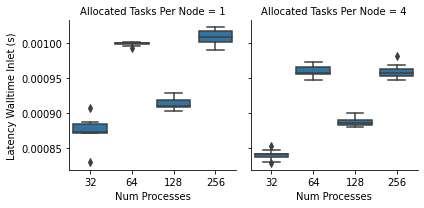

In [16]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Walltime Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-outlet-s+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-walltime-outlet-s+ext=.png


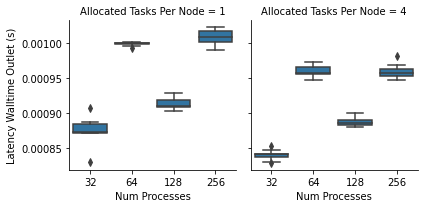

In [17]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Walltime Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Latency Simsteps

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-inlet+ext=.png


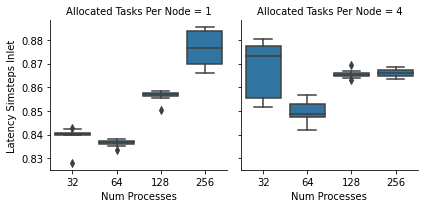

In [18]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Simsteps Inlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=latency-simsteps-outlet+ext=.png


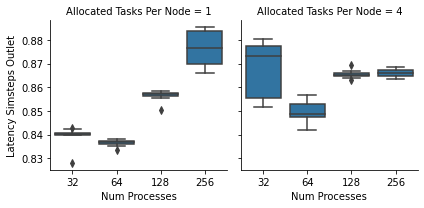

In [19]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Simsteps Outlet',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Delivery Failure Rate

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-failure-rate+ext=.png


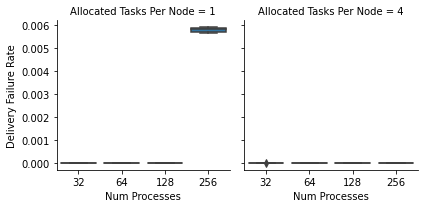

In [20]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Delivery Failure Rate',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Delivery Burtiness

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-burstiness+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=delivery-burstiness+ext=.png


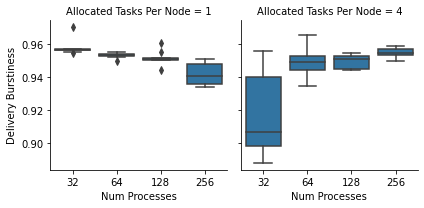

In [21]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Delivery Burstiness',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Simstep Period

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-inlet-s+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-inlet-s+ext=.png


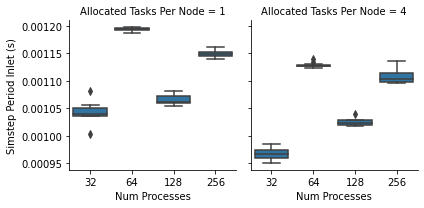

In [22]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Simstep Period Inlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-outlet-s+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=endstate_sumedbyrep+viz=facet-boxplot+x=num-processes+y=simstep-period-outlet-s+ext=.png


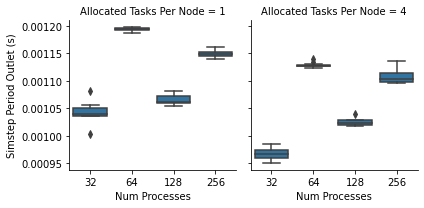

In [23]:
tp.tee(
    facet_boxplot,
    data=df_world_sum,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Simstep Period Outlet (s)',
    showfliers=True,
    teeplot_outattrs={
        **{
            'transform' : 'endstate_sumedbyrep',
        },
        **nbm.collate_outattr_metadata(),
    }
)

# Live Snapshot Analysis

In [24]:
def facet_boxplot(*, data, facet, x, y, showfliers=False):
    g = sns.FacetGrid(
        data,
        col=facet,
        margin_titles=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x,
        y,
        showfliers=showfliers,
    )

## Latency Walltime

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-walltime-inlet-ns+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-walltime-inlet-ns+ext=.png


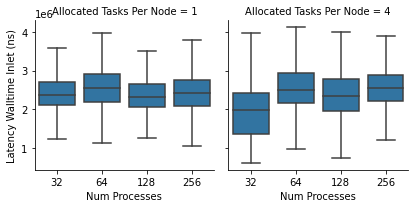

In [25]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Walltime Inlet (ns)',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-walltime-outlet-ns+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-walltime-outlet-ns+ext=.png


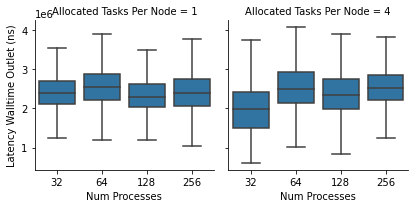

In [26]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Walltime Outlet (ns)',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Latency Simsteps

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-simsteps-inlet+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-simsteps-inlet+ext=.png


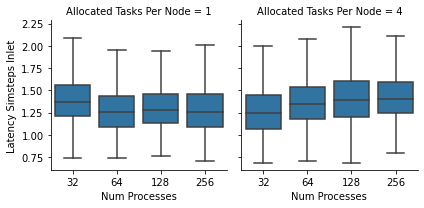

In [27]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Simsteps Inlet',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-simsteps-outlet+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=latency-simsteps-outlet+ext=.png


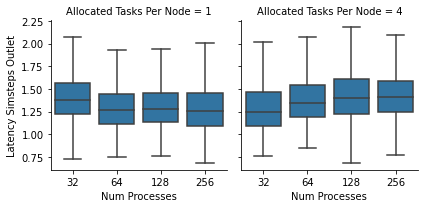

In [28]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Latency Simsteps Outlet',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Delivery Failure Rate

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=delivery-failure-rate+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=delivery-failure-rate+ext=.png


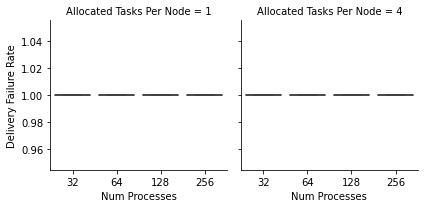

In [29]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Delivery Failure Rate',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Delivery Burstiness

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=delivery-burstiness+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=delivery-burstiness+ext=.png


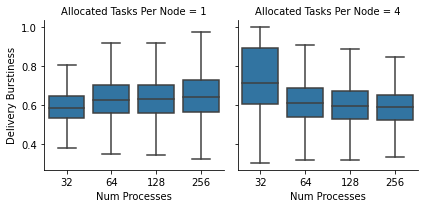

In [30]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Delivery Burstiness',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

## Simstep Period

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=simstep-period-inlet-ns+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=simstep-period-inlet-ns+ext=.png


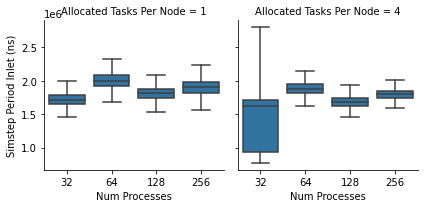

In [31]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Simstep Period Inlet (ns)',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=simstep-period-outlet-ns+ext=.pdf
teeplots/facet=allocated-tasks-per-node+transform=snapshot_diffs+viz=facet-boxplot+x=num-processes+y=simstep-period-outlet-ns+ext=.png


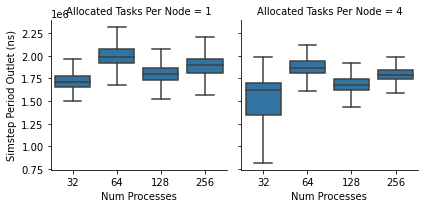

In [32]:
tp.tee(
    facet_boxplot,
    data=df_snapshot_diffs,
    facet='Allocated Tasks Per Node',
    x='Num Processes',
    y='Simstep Period Outlet (ns)',
    showfliers=False,
    teeplot_outattrs={
        **{
            'transform' : 'snapshot_diffs',
        },
        **nbm.collate_outattr_metadata(),
    }
)

In [33]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df_snapshot_diffs[
    (df_snapshot_diffs['Latency Simsteps Inlet'] > 100)
]

,Process Instance UUID,Snapshot,Async Mode,Num Nodes,Allocated Tasks Per Node,Num Processes,Replicate,proc,Hostname,Num Inlets,Num Outlets,Num Puts Attempted,Num Try Puts Attempted,Num Blocking Puts,Num Try Puts That Succeeded,Num Puts That Succeeded Eventually,Num Blocking Puts That Succeeded Immediately,Num Puts That Succeeded Immediately,Num Puts That Blocked,Num Dropped Puts,Num Reads Performed,Num Reads That Were Fresh,Num Reads That Were Stale,Num Revisions Pulled,Num Try Pulls Attempted,Num Blocking Pulls,Num Blocking Pulls That Blocked,Num Revisions From Try Pulls,Num Revisions From Blocking Pulls,Num Pulls Attempted,Num Pulls That Were Laden Eventually,Num Blocking Pulls That Were Laden Immediately,Num Blocking Pulls That Were Laden Eventually,Num Pulls That Were Laden Immediately,Num Try Pulls That Were Laden,Num Try Pulls That Were Unladen,Net Flux Through Duct,Num Round Trip Touches Inlet,Num Round Trip Touches Outlet,Row Final Timepoint (ns) Inlet,Row Final Timepoint (ns) Outlet,Fraction Messages Delivered,Delivery Failure Rate,Fraction Messages Dropped,Fraction Try Pulls That Were Laden,Round Trip Touches Per Attempted Put,Round Trip Touches Per Attempted Pull,Round Trip Touches Per Runtime Nanosecond,Latency Simsteps Inlet,Latency Simsteps Outlet,Delivery Burstiness,Intermittancy,Inlet-Nanoseconds Elapsed,Outlet-Nanoseconds Elapsed,Simsteps Elapsed Inlet,Simsteps Elapsed Outlet,Simstep Period Inlet (ns),Simstep Period Outlet (ns),Latency Walltime Inlet (ns),Latency Walltime Outlet (ns)
2964,0dfb8ec8-64e3-47b3-8ed1-da437b315037,0,3,256,1,256,9,238,lac-417,218,218,130416,130416,0,74824,130416,0,74824,0,55592,395867.0,27832.0,368035.0,27832.0,132992.0,0.0,0.0,27832.0,0.0,132992.0,27832.0,0.0,0.0,27832.0,27832.0,105160.0,68376,164,164.0,1.006264e+09,1.016114e+09,0.573733,0.573733,0.573733,0.209276,0.001258,0.001233,1.613993e-07,795.219512,810.926829,0.407043,0.407043,2.193656e+11,2.215128e+11,598.238532,610.055046,1.682045e+06,1.665610e+06,1.337595e+09,1.350688e+09
2965,0dfb8ec8-64e3-47b3-8ed1-da437b315037,1,3,256,1,256,9,238,lac-417,218,218,132129,132129,0,51370,132129,0,51370,0,80759,402128.0,25153.0,376975.0,25153.0,134043.0,0.0,0.0,25153.0,0.0,134043.0,25153.0,0.0,0.0,25153.0,25153.0,108890.0,68188,72,206.0,1.013702e+09,1.020840e+09,0.388787,0.388787,0.388787,0.187649,0.000545,0.001537,2.017946e-07,1835.125000,650.694175,0.368877,0.368877,2.209870e+11,2.225431e+11,606.096330,614.876147,1.672509e+06,1.660237e+06,3.069263e+09,1.080307e+09
2966,0dfb8ec8-64e3-47b3-8ed1-da437b315037,2,3,256,1,256,9,238,lac-417,218,218,429652,429652,0,139754,429652,0,139754,0,289898,943884.0,52215.0,891669.0,52215.0,314628.0,0.0,0.0,52215.0,0.0,314628.0,52215.0,0.0,0.0,52215.0,52215.0,262413.0,122507,398,306.0,2.255676e+09,1.845055e+09,0.325273,0.325273,0.325273,0.165958,0.000926,0.000973,1.658487e-07,1079.527638,1028.196078,0.426221,0.426221,4.917373e+11,4.022219e+11,1970.880734,1443.247706,1.144501e+06,1.278405e+06,1.235521e+09,1.314451e+09
2967,0dfb8ec8-64e3-47b3-8ed1-da437b315037,3,3,256,1,256,9,238,lac-417,218,218,119769,119769,0,65325,119769,0,65325,0,54444,366180.0,23745.0,342435.0,23745.0,122060.0,0.0,0.0,23745.0,0.0,122060.0,23745.0,0.0,0.0,23745.0,23745.0,98315.0,68068,176,176.0,1.014340e+09,1.023635e+09,0.545425,0.545425,0.545425,0.194535,0.001469,0.001442,1.719362e-07,680.505682,693.522727,0.348842,0.348842,2.211261e+11,2.231525e+11,549.399083,559.908257,1.846271e+06,1.828220e+06,1.256398e+09,1.267912e+09
2968,0dfb8ec8-64e3-47b3-8ed1-da437b315037,4,3,256,1,256,9,238,lac-417,218,218,133039,133039,0,54216,133039,0,54216,0,78823,404289.0,24981.0,379308.0,24981.0,134763.0,0.0,0.0,24981.0,0.0,134763.0,24981.0,0.0,0.0,24981.0,24981.0,109782.0,68175,196,196.0,1.015280e+09,1.021948e+09,0.407520,0.407520,0.407520,0.185370,0.001473,0.001454,1.917906e-07,678.770408,687.566327,0.366425,0.366425,2.213309e+11,2.227847e+11,610.270642,618.178899,1.663655e+06,1.653159e+06,1.129240e+09,1.136657e+09
2969,0dfb8ec8-64e3-47b3-8ed1-da437b315037,